<h1>Image pre-processing for object-detection model</h1>
<p style="color:blue;font-size:18px;">Step 1: Read imges</p>

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

In [5]:
# Defining global variable path that contains train / train_resized folders
image_folder = "/Users/peisch/code/WebScraper/ComputerVision_WebScraper/Images"

# Function to load folder into arrays and then it returns that same array
def loadImages(path):
    image_files = sorted([os.path.join(path, 'train', file)
         for file in os.listdir(path + "/train") if file.endswith('.jpg')])
    return image_files

In [6]:
# Check number of images in training set
len(loadImages(image_folder))

388

<p style="color:blue;font-size:18px;">Step 2: Resize images</p>

In [7]:
# Display one image
def display_one(a, title1 = "Original"):
    plt.imshow(a), plt.title(title1)
    plt.xticks([]), plt.yticks([])
    plt.show()

# Display two images
def display(a, b, title1 = "Original", title2 = "Edited"):
    plt.subplot(121), plt.imshow(a), plt.title(title1)
    plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(b), plt.title(title2)
    plt.xticks([]), plt.yticks([])
    plt.show()

In [8]:
# Resize images into dimension determined and save resized images in new folder
# Generate a csv file including image information ie. origin weight/height, new width/height
# BE CAREFUL: we use "image_folder" global variable defined at the beginnning of the notebook

def resizing(data):
    
    # in the path given, create a folder for upcoming resized images if not existing
    os.chdir(image_folder)
    try:
        os.makedirs('train_resized')
    except FileExistsError:
        print("Directory 'train_resized' already exists. ")
        
    # Loop: for each image in the folder, store the 1/image, 2/origin size, 3/filename as imageId
    
    # create a dataframe to store information with determined typing for each column
    dtypes = np.dtype([
          ('imageId', str),
          ('origin_width', int),
          ('origin_height', int),
          ('new_width', int),
          ('new_height', int),
          ])
    empty_data = np.empty(0, dtype=dtypes)
    df = pd.DataFrame(empty_data)
    img_list = []
    
    # set working directory (folder) to store processed images
    working_dir = image_folder + "/train_resized/"
    os.chdir(working_dir)
        
    # setting dimemsion of the resized image and update count for processed images
    count:int = 0
    height:int = 220
    width:int = 220
    dim = (width, height) # dimension is a tuple
    res_img = []
    
    # for each absolute path in the list 'data':
    # 1/read image; 2/get its origin image and imageID; 3/update image list;
    # 4/store info in dataframe; 5/store resized image in created "train_resized" folder
    
    for imgStr in data:
        img = [cv2.imread(imgStr, cv2.IMREAD_UNCHANGED)]
        origin_size = img[0].shape # shape of each image is a tuple of (height, weight, channel)
        origin_width = origin_size[1]
        origin_height = origin_size[0]
        imageId = imgStr.rstrip('.jpg').lstrip(image_folder + "/train")
        img_list[len(img_list):] = [imageId] # equiv to "append" to a list
        #print(f"Original size : {img[0].shape} ; Image ID: {imageId}")
        
        # store info as a new row in the dataframe created above
        col_names = ['imageId', 'origin_width', 'origin_height', 'new_width', 'new_height']
        new_row = pd.DataFrame([[str(imageId), origin_width, origin_height, width, height]], columns = col_names)
        df = df.append(new_row)
        
        # resize image and store as .jpg in created folder
        res = cv2.resize(img[0], dim, interpolation=cv2.INTER_LINEAR)
        res_img.append(res)
        count = count + 1
        filename:str = imageId + ".jpg"
        cv2.imwrite(filename, res)
            
    # Checking the size after processing
    print("Resized image :", res_img[-1].shape)
    
    # Visualizing one of the images in the array
    example_image = res_img[-1]
    display_one(example_image)
    
    # Delete duplicates of the df
    # Save dataframe into a CSV file (write or override .csv file)
    df = df.drop_duplicates()
    df.to_csv('imageTable.csv', index = False)
            
    print(f"Resizing finished. \n [ {count} ] image(s) resized and stored in directory: {working_dir} .")  
    return img_list
    
    

<p style="color:blue;font-size:18px;">Step 3: Recalculate image annotations</p>

In [9]:
def get_label(images):
    working_dir = image_folder + '/train/Label'
    os.chdir(working_dir)
    
    dtypes = np.dtype([
          ('class', str),
          ('origin_xmin', int),
          ('origin_ymin', int),
          ('origin_xmax', int),
          ('origin_ymax', int),
          ('imageId', str)
          ])
    #empty_data = np.empty(0, dtype=dtypes)
    #df = pd.DataFrame(empty_data)
    
    image_buffer:str = ""
    info:list = []
    
    for img in images:
        image_buffer = img
        filename = img + '.txt'
        f = open(filename,"r")
        content = f.read()
        # parse content and store in info list
        annotations = content.lstrip().rstrip().split('\n')
        # each_annot is a string with shape: 'Dress', '483.84', '228.734651', '691.2', '683.0'
        for each_annot in annotations:
            each_annot = each_annot.replace(",\n", ", ")
            dress:list = each_annot.split(" ") #list
            dress.append(image_buffer)
            info[len(info):] = [dress]
        f.close  
    
    col_names = ['class','origin_xmin','origin_ymin','origin_xmax','origin_ymax','imageId']
    df = pd.DataFrame(info, columns = col_names)
    
    os.chdir(image_folder + '/train_resized/')
    df.to_csv('labelTable.csv', index = False)
    
    return info

In [10]:
# Establish jointure on iamgeTable and labelTable on imageId

# Intermediate function to be call in 'compiler' to compute ratio
def compute_ratio (coordinate, size):
    ratio = coordinate/size if size != 0 else 0
    return ratio

# Intermediate function to be call in 'compiler' to new annotation
def normalise_annot(ratio, new_size):
    return ratio * new_size

# Intermediate function
def write_filename(imgStr):
    filename:str = imgStr + ".jpg"
    return filename

# Main Function to compile 2 tables and add new columns
def compiler():
    # Load intermediate tables
    os.chdir(image_folder + '/train_resized/')
    df_image = pd.read_csv('imageTable.csv')
    df_label = pd.read_csv('labelTable.csv')
    
    # Establish jointure on 2 tables
    result = pd.merge(df_image, df_label, how='right', on=['imageId', 'imageId'])
    
    # Calculate ratio to be applied in the new annontation
    result['ratio_xmin']:float = result.apply(lambda x: compute_ratio(x.origin_xmin, x.origin_width), axis = 1)
    result['ratio_ymin']:float = result.apply(lambda x: compute_ratio(x.origin_ymin, x.origin_height), axis = 1)
    result['ratio_xmax']:float = result.apply(lambda x: compute_ratio(x.origin_xmax, x.origin_width), axis = 1)
    result['ratio_ymax']:float = result.apply(lambda x: compute_ratio(x.origin_ymax, x.origin_height), axis = 1)    
        
    # Calculate new annotation
    result['xmin']:float = result.apply(lambda x: normalise_annot(x.ratio_xmin, x.new_width), axis = 1)
    result['ymin']:float = result.apply(lambda x: normalise_annot(x.ratio_ymin, x.new_height), axis = 1)    
    result['xmax']:float = result.apply(lambda x: normalise_annot(x.ratio_xmax, x.new_width), axis = 1)
    result['ymax']:float = result.apply(lambda x: normalise_annot(x.ratio_ymax, x.new_height), axis = 1)
        
    # Create a copy and conserve only columns that we need for algorithm input
    copy = result.copy()
    copy['filename']:str = copy.apply(lambda x: write_filename(x.imageId), axis = 1)
    col_names = ['imageId', 'origin_width', 'origin_height', 'origin_xmin', 'origin_ymin', \
                 'origin_xmax', 'origin_ymax', 'ratio_xmin', 'ratio_ymin', 'ratio_xmax', 'ratio_ymax']
    copy.drop(col_names, axis=1, inplace=True)
    # Save the copy as csv file
    copy.to_csv("synthesisAnnotation.csv", index = False)
    
    return result

<p style="color:blue;font-size:18px;">Execute sequential functions</p>

Resized image : (220, 220, 3)


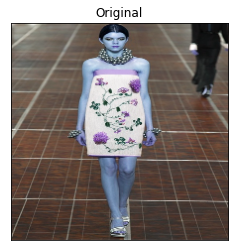

Resizing finished. 
 [ 388 ] image(s) resized and stored in directory: /Users/peisch/code/WebScraper/ComputerVision_WebScraper/Images/train_resized/ .


,imageId,origin_width,origin_height,new_width,new_height,class,origin_xmin,origin_ymin,origin_xmax,origin_ymax,ratio_xmin,ratio_ymin,ratio_xmax,ratio_ymax,xmin,ymin,xmax,ymax
0,0000a1229c025d92,768,1024,220,220,Dress,265.599744,214.400000,551.040000,949.120000,0.345833,0.209375,0.717500,0.926875,76.08326,46.06250,157.85000,203.91250
1,0000b366aaf9672a,1024,682,220,220,Dress,215.040000,333.962442,528.640000,681.360284,0.210000,0.489681,0.516250,0.999062,46.20000,107.72982,113.57500,219.79364
2,00015dd91eb8e269,1024,1024,220,220,Dress,51.200000,315.520000,458.880000,945.280000,0.050000,0.308125,0.448125,0.923125,11.00000,67.78750,98.58750,203.08750
3,00015dd91eb8e269,1024,1024,220,220,Dress,248.960000,366.080000,926.080000,1023.360000,0.243125,0.357500,0.904375,0.999375,53.48750,78.65000,198.96250,219.86250
4,00015dd91eb8e269,1024,1024,220,220,Dress,711.040000,343.680000,943.360000,1006.080000,0.694375,0.335625,0.921250,0.982500,152.76250,73.83750,202.67500,216.15000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
657,014a7f8aa65cdacc,1024,685,220,220,Dress,490.240000,409.719735,792.320000,684.359525,0.478750,0.598131,0.773750,0.999065,105.32500,131.58882,170.22500,219.79430
658,014aafb8e8aff4d7,1024,819,220,220,Dress,0.000000,155.603448,346.880000,818.359542,0.000000,0.189992,0.338750,0.999218,0.00000,41.79824,74.52500,219.82796
659,014b5857d4f99196,1024,683,220,220,Dress,284.160000,223.608736,396.160000,492.708004,0.277500,0.327392,0.386875,0.721388,61.05000,72.02624,85.11250,158.70536
660,014b66991e05e1d2,1024,683,220,220,Dress,304.000000,194.135920,686.080000,650.964568,0.296875,0.284240,0.670000,0.953096,65.31250,62.53280,147.40000,209.68112


In [11]:
# Load data with given image folder path
dataset = loadImages(image_folder)

# Call the resizing function over data and save imageTable.csv
images = resizing(dataset)

# Process all label .txt files and save labelTable.csv
get_label(images)

# Do the jointure of 2 tables and save syntheseAnnotation.csv
compiler()